# Tips / how-to

(from Vincent Esposito)

## 1) psana (offline analysis, resident analysis code)

`ssh psana`

Main experiment folder: `/cds/data/psdm/$HUTCH/$EXPERIMENT/`

Make a soft link to the experiment folder: `ln -s /cds/data/psdm/$HUTCH/$EXPERIMENT/ ./$SOFT_LINK`

Make a folder with your name in `exp_folder/results/` and put analysis code there.

## 2) ffb (online analysis):
Access data from Jupyter lab `/reg/data/drpsrcf/$HUTCH/$EXPERIMENT/scratch/hdf5/smalldata`

NOTE (from Hyeongtaek, Oct 1, 7:40 am): 
the folder above may not work, use `/cds/data/drpsrcf/$HUTCH/$EXPERIMENT/scratch/hdf5/smalldata`

The drp nodes are much faster than the offline psana system.


### Access data reduction code (smalldata_tools):

`ssh psffb`

`cd cds/data/drpsrcf/$HUTCH/$EXPERIMENT/scratch/smalldata_tools/`

The main producer file is `./examples/smalldata_producer.py`.
This file should be modified to parametrize the analysis functions (for example a ROI function) of the detectors.

### Make ROI:

`./examples/runSmallDataAna -r $RUN`

This will open an ipython console, with the classes `ana` and `anaps` available.

Create an average detector image with the command:

`anaps.AvImage(detname='jungfrau1M')`

Type `anaps.AvImage?` for information about the arguments (threshold, etc)

Once the average image is done, start region selection using `anaps.SelectRegion()` and follow instructions.

The selected region is then printed and can be copied from the terminal. This will typically be put in the `getRois` function definition in the producer file.

## 3) Run jobs from the elog

When setting the ROI, some runs might need to be reprocessed. This can be done by running `smd_FFB_XX` from the `Workflow/Control` tab in the elog.

Sometimes the automated data processing fails. In this case, just rerun the job after the run is over.

Job definitions can be edited in the `Workflow/Definitions` tab.

### References

Smalldata_tools documentation: https://confluence.slac.stanford.edu/display/PSDM/small+data%3A+Analysis+tools+for+aligned+data


## Note: 
The original scripts, `pp_ana_template_xpp_2d_binning.ipyb` and `ana_fun.py`, provided by Vincent can be found in `/cds/data/psdm/xpp/xpplw6419/results/vesp/`.

# Import modules
Have `ana_fun_xpplw6419_v#_#.py` in the folder where this script is run.

In [1]:
# %matplotlib widget
import os
import sys
import h5py
import tables
import cv2
import numpy as np
import matplotlib.pyplot as plt

import psana as ps
import ana_fun_xpplw6419_v1_0 as ana # change version if necessary

from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from pathlib import Path

# plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (10,5)
plt.rc('font', size=12)
length = 8
width = 1
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

print('-----------------')
print('Modules imported!')
print('-----------------')

-----------------
Modules imported!
-----------------


# Check smd files
smd = small data

The small data file (in the hdf5 format) will be automatically generated after each run ends.

The script setup for the small data production is taken care of by beam line staff and can be modified if necessary.

If any changes are made in the script setup (e.g., ROI change) during the beam time, the small data may need to be re-processed.

In [2]:
run = 202
exp = 'xpplw6419'
ffb = False

if ffb:
    p = Path('/cds/data/drpsrcf/{}/{}/scratch/hdf5/smalldata/'.format(exp[:3], exp))
#     print(p)
else:
    p = Path('/cds/data/psdm/{}/{}/hdf5/smalldata/'.format(exp[:3], exp))
#    p = Path('/cds/data/psdm/{}/{}/scratch/ffb/hdf5/smalldata/'.format(exp[:3], exp))
print(p.exists())
it = p.glob('{}_Run{:04d}.h5'.format(exp,run))
f = next(it)
print(it)
print('\n')
#print(it)
# Only for example. Comment or delete later
#f = Path('/cds/data/psdm/{}/{}/results/vesp/example_ccm_2d_scan.h5'.format(exp[:3],exp)) 
#f = Path('/cds/data/drpsrcf/xpp/xpplw6419/scratch/hdf5/smalldata/xpplw6419_Run0021.h5') 
rr = tables.File(f).root
h5 = h5py.File(f)
print('\n'.join(h5.keys())) # this shows the (top-level) group and dataset names under the root
print('\nLoaded data:', f)

True
<generator object Path.glob at 0x7f402b6e2850>


Sums
UserDataCfg
adc
damage
diodeU
ebeam
enc
epics
epicsUser
epix10k2M
epix10k2M_env
epix_2
epix_2_env
event_time
evr
fiducials
gas_detector
ipm2
ipm3
ipm_hx2
lightStatus
lombpm
lomdiode
scan
tt

Loaded data: /cds/data/psdm/xpp/xpplw6419/hdf5/smalldata/xpplw6419_Run0202.h5


In [ ]:
# rr.tt this outputs the subgroups under the group 'tt'
# rr.tt.ttCorr # this outputs the information about the dataset 'ttCorr'
# rr.tt.ttCorr[:] # this outputs the values of the dataset 'ttCorr'

rr.ebeam

# Make data and filter dictionaries

In [3]:
# Make data dictionary to find data in smd file (dictionary structure = {key : value})
dataDict = {'i0': ['ipm3','sum'],
            'fluo': ['epix_2','ROI_0_sum'],
            'scattIm': ['epix10k2M','azav_azav'],            
            'xon': ['lightStatus','xray'],
            'lon': ['lightStatus','laser'],
            'delay': ['enc','lasDelay'],
            'tt_fwhm': ['tt','FLTPOSFWHM'],
            'tt_amp': ['tt','AMPL'],
            'tt_corr': ['tt','ttCorr'],
            'energy': ['epics','ccm_E']
           }

"""
    Energy is now in epics/ccm_E

    It would be easy just change value for 'energy' for other scans in which other motors are moving
    For example, use 'energy': ['scan','var0']

    scan/var0 will be scanning value (in most times) and real motor name can be found if you check rr.scan
    For example, if you can xpp_com_wp, ['scan','var0'] is the same as ['scan','xpp_com_wp']
"""

# Initalize filter dictionary as identical to data dictionary, but with null filters
filters = {key: [] for key in dataDict.keys()}

# Set filters
filters['i0'] = [3000,35000]
filters['tt_amp'] = [0.03,0.5]
filters['tt_fwhm'] = [40,230]

#filters # this outputs the defined filters for the data

print('-----------------------------------')
print('dataDict and filters are generated.')
print('-----------------------------------')

-----------------------------------
dataDict and filters are generated.
-----------------------------------


# Check and utilize scattering data
Scattering data will be used for normalization.

## Display epix detector image

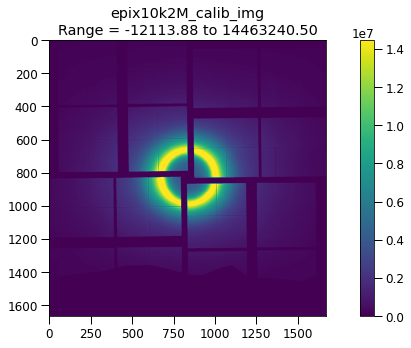

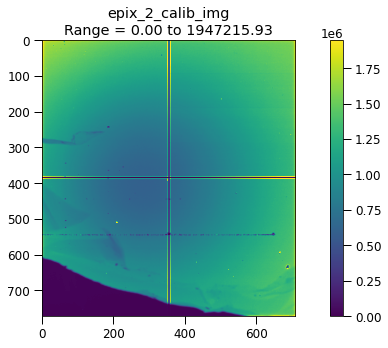

In [4]:
# Set color limits for image (percentile)
llim = 1
ulim = 99

imageList = list(rr.Sums._v_children)

for child in imageList:
    if child.endswith('_img'):
        if 'square' in child:
            continue
        im = rr.Sums[child][:]
        plt.figure('detector image' + child)
        plt.imshow(im, clim=(np.nanpercentile(im, llim), np.nanpercentile(im, ulim)))
        plt.title('{}\nRange = {:.02f} to {:.02f}'.format(child, np.nanpercentile(im, llim), np.nanpercentile(im, ulim)))
        plt.colorbar()
        plt.tight_layout()
        plt.show()

###  Two images wil be shown as outputs.
###  'epix10k2M_calib_img' is relevant to the scattering data.
###  'epix_2_calib_img' is relevant to the XAS data and can be ignored here.

## Check proper Q range for normalization

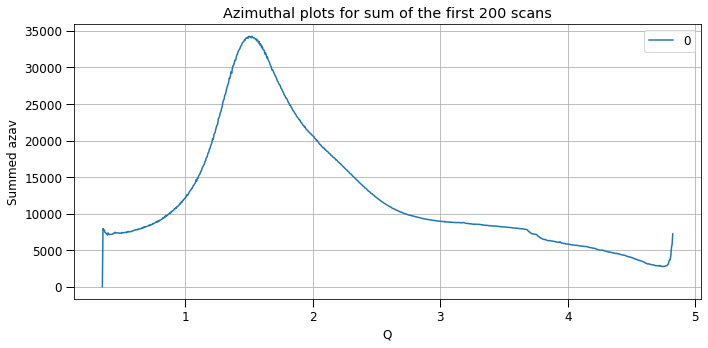

In [5]:
## Quick plot of Summed azav vs Q to define Q range

nShotPlot = 200 # the number of shots to sum

ims = np.sum(rr['/'.join(dataDict['scattIm'])][:nShotPlot], axis = 0)
qvalues = rr.UserDataCfg.epix10k2M.azav__azav_q[:]  # this should be Q

for i in range(ims.shape[0]):
    plt.plot(qvalues, ims[i,:], label = str(i))
plt.title('Azimuthal plots for sum of the first {} scans'.format(nShotPlot))
plt.xlabel('Q')
plt.ylabel('Summed azav')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Make summed scattering data

In [6]:
# Set Q range
qMin = 1
qMax = 2.5

qvalues = rr.UserDataCfg.epix10k2M.azav__azav_q[:] # get Q values

q1 = np.where(qvalues >= qMin)[0][0]
q2 = np.where(qvalues <= qMax)[0][-1]

# Save the summed scattering data in the variable 'scattQ'
scattQ = np.nansum(rr['/'.join(dataDict['scattIm'])][:,:,q1:q2], axis = (1,2))

print('-------------------------')
print('Using Q from {} to {}\nDone!'.format(qMin,qMax))
print('-------------------------')
# Note: Filters for scattQ may be added, but the filters for I0 should be equivalent (check correlation).

-------------------------
Using Q from 1 to 2.5
Done!
-------------------------


In [ ]:
print(np.shape(scattQ))
print(scattQ)

# Histograms

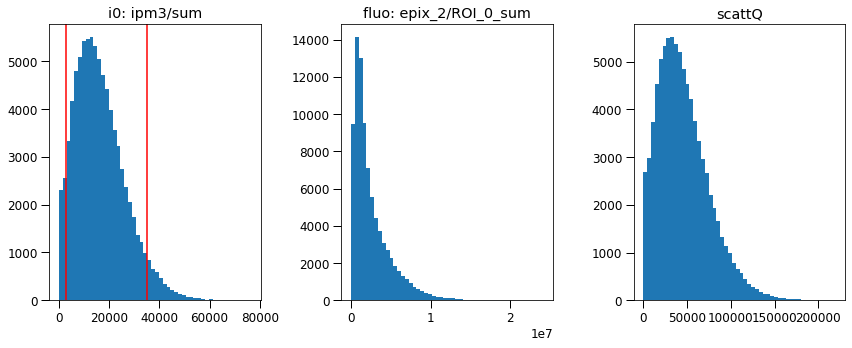

Vertical red lines indicate the filter range.


In [7]:
# For i0 (ipm3) and fluo (epix_2)
pltList = ['i0','fluo']
fig, ax = plt.subplots(ncols=len(pltList)+1, figsize=(12,5))
for npl,pl in enumerate(pltList):
    ax[npl].hist(rr['/'.join(dataDict[pl])], bins=50)
    if filters[pl]:
        for nl in range(2):
            ax[npl].axvline(filters[pl][nl], color = 'red')
    ax[npl].set_title(pl+': '+'/'.join(dataDict[pl]))

# For scattQ from epix10k2M
ax[-1].hist(scattQ, bins=50)
ax[-1].set_title('scattQ')
#for nl in range(2):
#    ax[-1].axvline(filters['scattQ'][nl], color = 'red')

plt.tight_layout()
plt.show()

print('Vertical red lines indicate the filter range.')

# Correlations

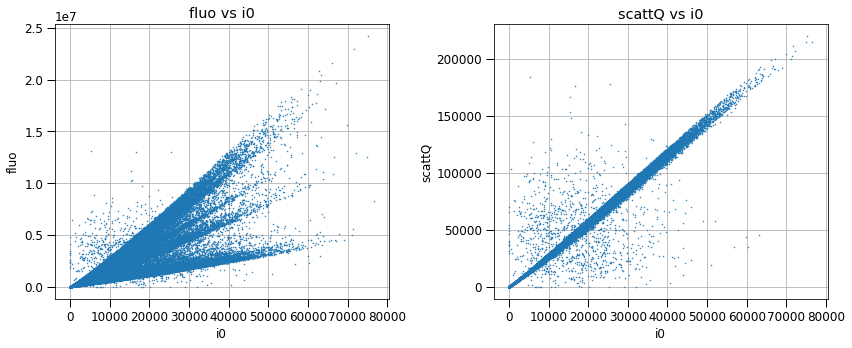

In [8]:
# fluo vs i0
pltList = ['fluo']
fig, ax = plt.subplots(ncols = len(pltList)+1, figsize = (12,5))
for npl,pl in enumerate(pltList):
    ax[npl].plot(rr['/'.join(dataDict['i0'])][:], rr['/'.join(dataDict[pl])][:], '.',  markersize=1)
    ax[npl].set_ylabel(pl)
    ax[npl].set_xlabel('i0')
    ax[npl].set_title('{} vs i0'.format(pl))
    ax[npl].grid()

# scattQ (summed azav) vs i0
ax[-1].plot(rr['/'.join(dataDict['i0'])][:], scattQ, '.',  markersize=1)
ax[-1].set_xlabel('i0')
ax[-1].set_ylabel('scattQ')
ax[-1].set_title('scattQ vs i0')
ax[-1].grid()

plt.tight_layout()
plt.show()

# TimeTool
Reference: https://confluence.slac.stanford.edu/display/PSDM/TimeTool

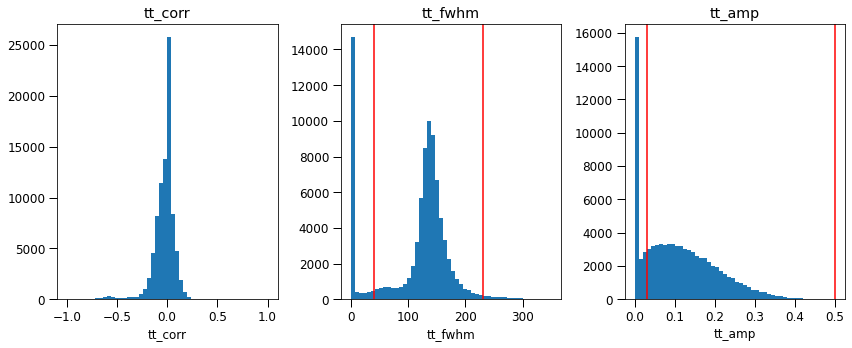

Vertical red lines indicate the filter range.


In [9]:
# Set bins for histograms
ttPL = {'tt_corr': np.linspace(-1,1,51),
        'tt_fwhm': np.linspace(0,350,51),
        'tt_amp':  np.linspace(0,0.5,51)
       }

if 'tt' in rr:
    fig, ax = plt.subplots(ncols=3, figsize=(12,5))
    ax = ax.ravel()
    for n,p in enumerate(ttPL):
        ax[n].set_title(p)
        ax[n].hist(rr['/'.join(dataDict[p])], bins=ttPL[p]) 
        ax[n].set_xlabel(p)
        if filters[p]:
            for nl in range(2):
                ax[n].axvline(filters[p][nl], color = 'red')
plt.tight_layout()
plt.show()

print('Vertical red lines indicate the filter range.')

# Check filters

In [10]:
for f in filters:
    if filters[f]:
        data = rr['/'.join(dataDict[f])][:]
        filt = np.logical_and(data > filters[f][0], data < filters[f][1])
        r1 = sum(np.logical_not(filt))/filt.shape[0]
        # r2 = np.nansum(data[np.logical_not(filt)])/np.nansum(data)
        print('{:10s}:  Filter eliminates {:.1%} of the shots. Range:  {:5} - {:5}'.format(f,r1,*filters[f]))
    else:
        print('{:10s}:  No filter'.format(f))

i0        :  Filter eliminates 10.6% of the shots. Range:   3000 - 35000
fluo      :  No filter
scattIm   :  No filter
xon       :  No filter
lon       :  No filter
delay     :  No filter
tt_fwhm   :  Filter eliminates 21.2% of the shots. Range:     40 -   230
tt_amp    :  Filter eliminates 24.5% of the shots. Range:   0.03 -   0.5
tt_corr   :  No filter
energy    :  No filter


# Get variables and apply filters

Generally the variable (motor) that is scanned is put in the `scan` field of the smalldata file. However, the fast laser delay is not properly captured and does not end up there. In case of a fast laser delay scan, the scan variable to use is `enc/lasDelay`. A few other motors are like that, please inquire the beamline staff or the data POC.

Energy: `epics/ccm_E`

In [ ]:
rr.scan.varStep[:]

In [ ]:
rr.enc.lasDelay[:]

In [11]:
intensity = rr['/'.join(dataDict['fluo'])][:] # signal

energy = rr['/'.join(dataDict['energy'])][:] # energy

delay = rr['/'.join(dataDict['delay'])][:] # nominal delay
delay = delay + rr['/'.join(dataDict['tt_corr'])][:] # nominal delay + tt correction

lon = rr['/'.join(dataDict['lon'])][:] # lightStatus for laser on
xon = rr['/'.join(dataDict['xon'])][:] # lightStatus for x-ray on
print('Laser on fraction : {:.02f}'.format(lon.sum()/lon.shape[0]))



""" I0 filter """
i0 = rr['/'.join(dataDict['i0'])][:]
i0_filt = np.logical_and(i0>filters['i0'][0], i0<filters['i0'][1])


""" Timing tool filter """
tt_filt = np.ones_like(i0_filt)
if 'tt' in rr:
    ttf = ['tt_amp','tt_fwhm'] # dictionary entries in tt to filter on
    for fil in ttf:
        tt_filt = np.logical_and.reduce([tt_filt,
                                         rr['/'.join(dataDict[fil])][:] > filters[fil][0],
                                         rr['/'.join(dataDict[fil])][:] < filters[fil][1]]
                                       )
        print('After applying {} [{} - {}], {} shots remain'.format(fil,filters[fil][0],filters[fil][1],sum(tt_filt)))


""" Check the number of shots remaining after applying filters """
print('\n\nRemaining shots after applying filters')
print('\nLaser on')
print('lon                  : {}'.format(sum(lon)))
print('lon + xon            : {}'.format(sum(np.logical_and.reduce([lon, xon]))))
print('lon + xon + i0       : {}'.format(sum(np.logical_and.reduce([lon, xon, i0_filt]))))
print('lon + xon + i0 + tt  : {}'.format(sum(np.logical_and.reduce([lon, xon, i0_filt, tt_filt]))))

print('\nLaser off')
print('loff                 : {}'.format(sum(np.logical_not(lon))))
print('loff + xon           : {}'.format(sum(np.logical_and.reduce([np.logical_not(lon), xon]))))
print('loff + xon + i0      : {}'.format(sum(np.logical_and.reduce([np.logical_not(lon), xon, i0_filt]))))


""" Combine filters """
filt_lon = np.logical_and.reduce([lon, xon, i0_filt, tt_filt])
filt_loff = np.logical_and.reduce([np.logical_not(lon), xon, i0_filt])
event=np.arange(intensity.shape[0])

""" Create dictionary (or pandas dataframe) with the relevant variables """
data_to_bin_lon = {'delay': delay[filt_lon],
                   'energy': energy[filt_lon],
                   'i0': i0[filt_lon],
                   'scattQ': scattQ[filt_lon],
                   'intensity': intensity[filt_lon],
                   'event':event[filt_lon]
                  }

data_to_bin_loff = {'delay': delay[filt_loff],
                    'energy': energy[filt_loff],
                    'i0': i0[filt_loff],
                    'scattQ': scattQ[filt_loff],
                    'intensity': intensity[filt_loff],
                    'event': event[filt_loff]
                   }
print("\n---------------------------------------------------------")
print("'data_to_bin_lon' and 'data_to_bin_loff' are generated.")
print("---------------------------------------------------------")
print(event)

Laser on fraction : 0.86
After applying tt_amp [0.03 - 0.5], 64653 shots remain
After applying tt_fwhm [40 - 230], 63306 shots remain


Remaining shots after applying filters

Laser on
lon                  : 73402
lon + xon            : 72676
lon + xon + i0       : 65550
lon + xon + i0 + tt  : 59141

Laser off
loff                 : 12234
loff + xon           : 12114
loff + xon + i0      : 10963

---------------------------------------------------------
'data_to_bin_lon' and 'data_to_bin_loff' are generated.
---------------------------------------------------------
[    0     1     2 ... 85633 85634 85635]


In [ ]:
plt.plot(data_to_bin_loff['energy'][500:700])
plt.show()
plt.plot(data_to_bin_loff['energy'][:2000])
plt.show()

# Bin loff, then normalize then diff for each lon point

In [12]:
#some functions

def smoothOffshots(offshots, energy):
    ''' averages all off shots for each energy step in experiment time'''
    smoothOff = np.full_like(offshots, np.nan)
    orderedOff = offshots
    n = [0] #index for first bin at given energy
    for i in range(offshots.shape[0]):
        try:
            if int(energy[i]*10000) != int(energy[i+1]*10000):
                #fill all smoothOff with average value for given energy
                smoothOff[n[-1]: i+1] = np.nanmean(orderedOff[n[-1]:i+1],0)
                n.append(i+1)
        except: #last bin
            smoothOff[n[-1]:] = temp= np.nanmean(orderedOff[n[-1]:],0)
            n.append(i)         
    return smoothOff

def Esteps(events,energy,ewidth=0):
    '''for all events sort based on energy step, make two arrays, one for energy step, and one with first event in step'''
    eindex=[0] #index of first bin at given energy
    esteps=[energy[0]]
    for i in range(energy.shape[0]):
        try:
            if ewidth==0:
                aa=(int(energy[i]*10000) != int(energy[i+1]*10000))
            else:
                aa= not np.logical_and((int(energy[i]*10000) >= int((energy[i+1]-ewidth)*10000)),(int(energy[i]*10000) < int((energy[i+1]+ewidth)*10000)))
            if aa:
                esteps.append(np.nanmean(energy[eindex[-1]:i+1],0))
                eindex.append(i+1)
        except: #last bin
            esteps.append(np.nanmean(energy[eindex[-1]:],0))
            eindex.append(i)
            
    eindex=np.array(eindex)
    esteps=np.array(esteps)
    return eindex,esteps

def smoothOffshots2(offshots,event1,eInd):
    ''' SUM all off shots for each energy step in experiment time, returns more things than v1.  uses values from Esteps'''
    
    smoothOff = np.full_like(offshots, np.nan)
    smoothOff2=[]
    #for each 
    for ii,ee in enumerate(eInd):
        try:
            Ind1=np.nonzero(np.logical_and(event1>=ee, event1<eInd[ii+1])) #find all points in given eStep
            temp=np.nansum(offshots[Ind1],0)
            if np.all(np.isnan(offshots[Ind1])):
                temp=np.nan
#                 print('all nan for eInd=',ee, temp)
            smoothOff[Ind1]=temp
            smoothOff2.append(temp)
        except:
            Ind1=np.nonzero(event1>=ee) #last bin
            temp=np.nansum(offshots[Ind1],0)
            if np.all(np.isnan(offshots[Ind1])):
                temp=np.nan
#                 print('all nan for eInd=',ee,temp)
            smoothOff[Ind1]=temp
            smoothOff2.append(temp)
    smoothOff2=np.array(smoothOff2)
    return smoothOff,smoothOff2

##should add nan check for smoothOffshots2        

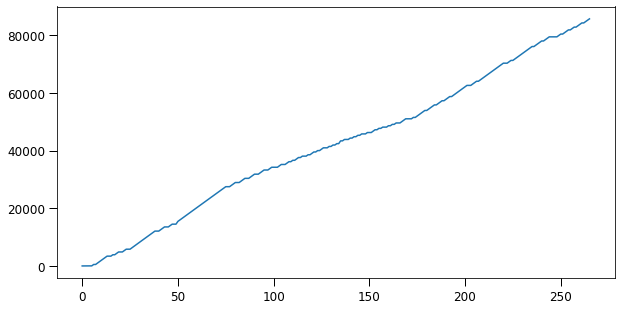

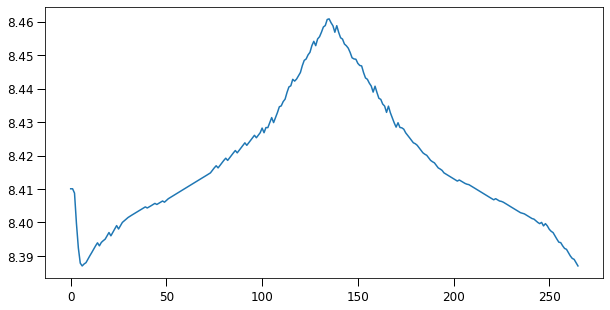

nan? 54 Eind [   15    19  3395  3396  4851  5802  5806 12075 12076 13519 14481 27466
 27467 28910 28911 30354 31802 31803 33246 34202 34204 34206 35168 37570
 38054 38055 38530 39494 40938 40940 41902 42386 43346 43841 44310 45270
 45754 47678 48111 48112 49550 50996 57253 62569 62570 64009 70269 70270
 76041 79397 79401 79402 80361 82769]


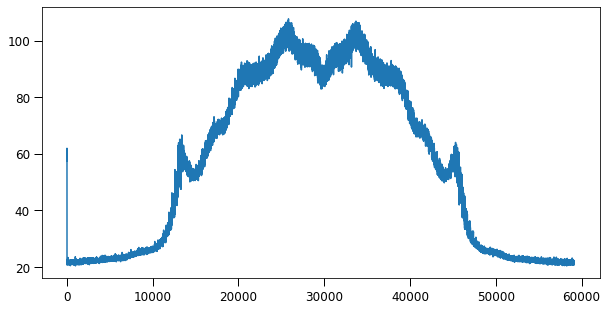

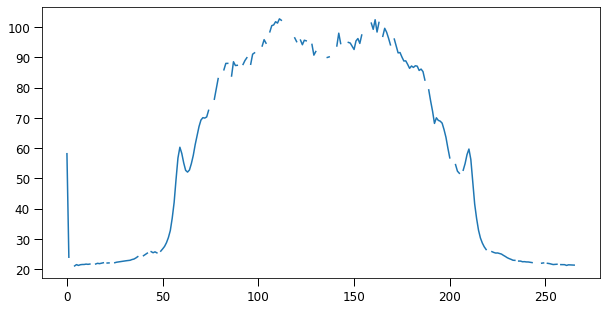

In [14]:
#find energy steps
eind,estep=Esteps(event,energy,ewidth=2e-4)
plt.plot(eind)
plt.show()
plt.plot(estep)
plt.show()
# eind,estep=Esteps(event,energy,ewidth=6e-4)
#bin loff wrt energy step
junk,iStep=smoothOffshots2(data_to_bin_loff['intensity'],data_to_bin_loff['event'],eind)
junk,I0Step=smoothOffshots2(data_to_bin_loff['i0'],data_to_bin_loff['event'],eind)
junk,QStep=smoothOffshots2(data_to_bin_loff['scattQ'],data_to_bin_loff['event'],eind)

#nan check of smoothed loff
ind2=np.nonzero(np.isnan(iStep))
print('nan?', len(ind2[0]), 'Eind',eind[ind2])

#normalize loff
loff_normI0=iStep/I0Step
loff_normQ=iStep/QStep

# normalize lon
intensity_lon_normQ = data_to_bin_lon['intensity'] / data_to_bin_lon['scattQ']
intensity_lon_normI0 = data_to_bin_lon['intensity'] / data_to_bin_lon['i0']

# plt.plot(QStep)
# plt.show()
plt.plot(intensity_lon_normQ)#marker='.')
plt.show()
plt.plot(loff_normQ)
plt.show()

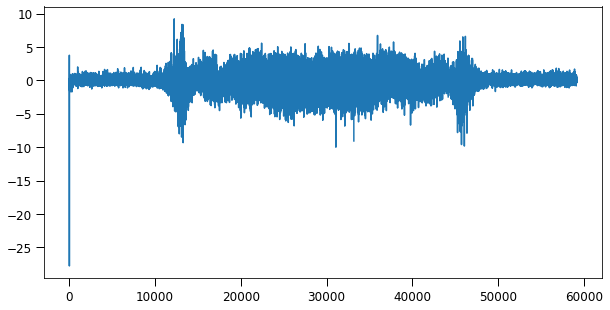

In [15]:
#subtract: lon-loff

#inputs
eInd=eind
event1=data_to_bin_lon['event']
diff_lon_nQ=np.full_like(intensity_lon_normQ,np.nan)
diff_lon_nI0=np.full_like(intensity_lon_normI0,np.nan)

#do subtraction for each estep
for ii,ee in enumerate(eInd):
    try:
        Ind1=np.nonzero(np.logical_and(event1>=ee, event1<eInd[ii+1])) #find all points in given eStep
#         print(Ind1)
        for jj in Ind1:
            diff_lon_nQ[jj]=intensity_lon_normQ[jj]-loff_normQ[ee]
            diff_lon_nI0[jj]=intensity_lon_normI0[jj]-loff_normI0[ee]
    except:
        Ind1=np.nonzero(event1>=ee) #last bin
        for jj in Ind1:
            diff_lon_nQ[jj]=intensity_lon_normQ[jj]-loff_normQ[ii]
            diff_lon_nI0[jj]=intensity_lon_normI0[jj]-loff_normI0[ii]


diff_to_binQ = {'delay': delay[filt_lon],
                   'energy': energy[filt_lon],
                   'intensity': diff_lon_nQ,
                  }
diff_to_binI0 = {'delay': delay[filt_lon],
                   'energy': energy[filt_lon],
                   'intensity': diff_lon_nI0,
                  }
plt.plot(diff_lon_nQ)

In [16]:
## bin 

t_binCenters = np.arange(-0.5,3.1, 0.1)
e_binCenters = np.array([8.387 , 8.388 , 8.389 , 8.39 , 8.391 , 8.392 , 8.393 ,
8.394 , 8.395 , 8.396 , 8.397 , 8.398 , 8.399 , 8.4 ,
8.4005 , 8.401 , 8.4015 , 8.40185, 8.4022 , 8.40255, 8.4029 ,
8.40325, 8.4036 , 8.40395, 8.4043 , 8.40465, 8.405 , 8.40535,
8.4057 , 8.40605, 8.4064 , 8.40675, 8.4071 , 8.40745, 8.4078 ,
8.40815, 8.4085 , 8.40885, 8.4092 , 8.40955, 8.4099 , 8.41025,
8.4106 , 8.41095, 8.4113 , 8.41165, 8.412 , 8.41235, 8.4127 ,
8.41305, 8.4134 , 8.41375, 8.4141 , 8.41445, 8.4148 , 8.41555,
8.4163 , 8.41705, 8.4178 , 8.41855, 8.4193 , 8.42005, 8.4208 ,
8.42155, 8.4223 , 8.42305, 8.4238 , 8.42455, 8.4253 , 8.42605,
8.4268 , 8.4283 , 8.4298 , 8.4313 , 8.4328 , 8.4348 , 8.4368 ,
8.4388 , 8.4408 , 8.4428 , 8.4448 , 8.4468 , 8.4488 , 8.4508 ,
8.4528 , 8.4548 , 8.4568 , 8.4588 , 8.4608 ])

binned_data_I0, binEdges_lon = ana.bin_data_ndim(diff_to_binI0, bin_keys=['delay','energy'], statistic='mean',
                                                  bin_centers=[t_binCenters,e_binCenters])
binned_data_Q, binEdges_lon = ana.bin_data_ndim(diff_to_binQ, bin_keys=['delay','energy'],statistic='mean',
                                                  bin_centers=[t_binCenters,e_binCenters])

### plot

(36, 89)


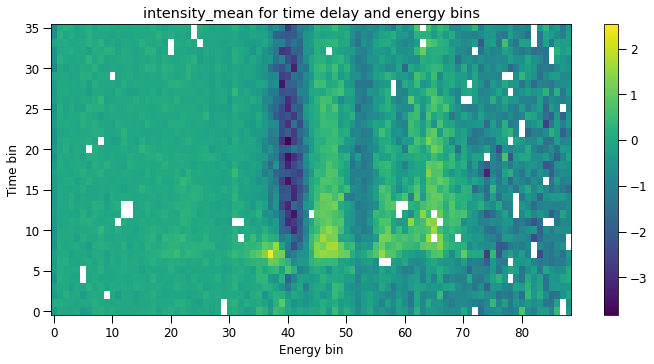

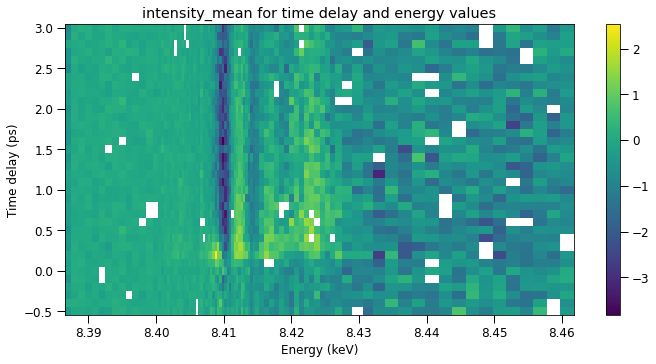

[-0.23125939  0.07703063  0.03058101 -0.03100598  0.02321878         nan
  0.04314544  0.00908676  0.16104938 -0.05634991 -0.02382675  0.00244316
  0.10222927  0.01537666  0.008417   -0.19425837  0.0259023  -0.04079172
 -0.03118982 -0.01529707  0.18643532 -0.00667269 -0.09739386 -0.05657032
 -0.0724383  -0.02593732 -0.07869436 -0.05458817 -0.03159491 -0.12917153
 -0.11307405  0.07144522  0.11053328 -0.0196853  -0.17266811  0.33569128
 -0.08085315  0.27215032  0.39470968 -0.23662123  0.75104033  0.25607319
 -0.97184437 -0.6723738  -0.0966924   0.131015   -0.0703601  -0.60084582
  0.00613979 -0.19332025  0.08585767  0.37662195 -0.78373537 -0.69125162
 -0.50579267 -0.7160413  -0.07210482 -0.48842733 -0.14583259 -0.69645794
 -1.06907616 -1.10847262 -0.37837069 -0.93907027 -0.27154432 -0.30747304
  0.10969235 -0.18395163 -0.5070154  -0.55857831 -0.81263317 -1.68023913
 -0.88698902 -0.90083052 -1.03298647 -0.44242493 -1.35850675 -0.54110575
 -0.03830223 -0.23504285 -1.38564624 -0.684602   -0

In [17]:
## plot binned data

dn = binned_data_Q # binned_data_lon or binned_data_loff
data = 'intensity_mean' # 'intensity_sum', 'delay_sum', 'energy_sum', 'i0_sum', 'scattQ_sum', or 'counts'

print(np.shape(dn[data])) # check dimension of data

# w.r.t bins of time delay and energy
plt.imshow(dn[data], aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Energy bin')
plt.ylabel('Time bin')
plt.tight_layout()
plt.title('{} for time delay and energy bins'.format(data))
plt.show()

# w.r.t values of time delay and energy
# plt.contourf(dn['energy_bin'], dn['delay_bin'], dn[data])
plt.pcolormesh(dn['energy_bin'], dn['delay_bin'], dn[data], shading='auto')
plt.colorbar()
plt.xlabel('Energy (keV)')
plt.ylabel('Time delay (ps)')
plt.tight_layout()
plt.title('{} for time delay and energy values'.format(data))
plt.show()

print(dn[data][5])

In [ ]:
output_path = '/cds/data/psdm/xpp/xpplw6419/scratch/limh/output/test_order/SLR-100fs' # change to your output folder
name = '{}_run_{:3d}.h5'.format(exp,run) # 'xpplw6419_run_###.h5'; change if you want different filename
fname = output_path+'/'+name

if not os.path.isdir(output_path):
    os.makedirs(output_path)


""" 
    Saving the following data in the hdf5 format (this will overwrite for the same filename):
        - binned data for laser on
        - binned data for laser off
        - normalized data (for both scattQ- and I0-normalization)
        - pump-probe data (for both scattQ- and I0-normalization)
"""
with h5py.File(fname, 'w') as hf:
    hf.create_group('Pump-probe_data')
    hf.create_dataset('Normalized_loff_Q',data=loff_normQ)
    hf.create_dataset('Normalized_loff_I0',data=loff_normI0)
    hf.create_dataset('Esteps',data=estep) 
    for key, value in binned_data_Q.items():
        hf.create_dataset('Pump-prob_data/ppQ/{}'.format(key), data=value)
    for key, value in binned_data_I0.items():
        hf.create_dataset('Pump-prob_data/ppI0/{}'.format(key), data=value)


print('---------------------------------------------------------------------------------------')
print('Saved data file: {}'.format(fname))
print('---------------------------------------------------------------------------------------')

# Check filtered data

In [ ]:
# Quick check and plot for the filtered data for variables in 'data_to_bin_lon' or 'data_to_bin_loff'
# %matplotlib widget
dn = data_to_bin_loff # data_to_bin_lon or data_to_bin_loff
data = 'intensity' # 'delay', 'energy', 'i0', 'scattQ', or 'intensity'
# data2 = 'delay'
fig, ax = plt.subplots(ncols=2, figsize=(15,5), )

# for all the shots
ax[0].plot(dn[data]) 
ax[0].set_ylabel('{}'.format(data))
ax[0].set_xlabel('shot')

# for the small number of shots
ax[1].plot(dn[data][:2000]) 
ax[1].set_xlabel('shot')

#plt.tight_layout()
fig.suptitle('{}'.format(data), fontsize='x-large')
plt.show()

# Check scan coverage

In [ ]:
# Scattering plot w.r.t. energy and time delay

dn = data_to_bin_lon # data_to_bin_lon or data_to_bin_loff
data = 'intensity' # 'delay', 'energy', 'i0', 'scattQ', or 'intensity'

plt.figure('scan coverage')
plt.scatter(dn['energy'], dn['delay'], c = dn[data], s = 1)
plt.xlabel('Energy (keV)')
plt.ylabel('Time delay (ps)')
plt.title('Scan coverage for run {}'.format(run))
plt.colorbar()
plt.tight_layout()
plt.show()

# N-dimensional binning

Bin along multiple axes; in 2-d measurement, bin along 'time delay' and 'energy'.

For 1-d measurement, n-dimensional binning can be still used by following one of these:
- just give one bin_keys and one bin_centers
- for the variable that is not scanning, give two large separated values in binCenters (e.g., one where scan is done and the other having very different value) so that all the data fall into one bin for this variable

In [ ]:
# Set bin centers
#t_binCenters = np.arange(-5,5,0.2) # (start, stop. step)
t_binCenters = np.arange(-0.5,3, 0.05)
#e_binCenters = np.array([8.395 , 8.397 , 8.399 , 8.401 , 8.403 , 8.4035 , 8.404 ,
#8.4045 , 8.40485, 8.4052 , 8.40555, 8.4059 , 8.40625, 8.4066 ,
#8.40695, 8.4073 , 8.40765, 8.408 , 8.40835, 8.4087 , 8.40905,
#8.4094 , 8.40975, 8.4101 , 8.41045, 8.4108 , 8.41115, 8.4115 ,
#8.41185, 8.4122 , 8.41255, 8.4129 , 8.41325, 8.4136 , 8.41395,
#8.4143 , 8.41465, 8.415 , 8.41535, 8.4157 , 8.41605, 8.4164 ,
#8.41675, 8.4171 , 8.41745, 8.4178 , 8.41855, 8.4193 , 8.42005,
#8.4208 , 8.42155, 8.4223 , 8.42305, 8.4238 , 8.42455, 8.4253 ,
#8.42605, 8.4268 , 8.42755, 8.4283 , 8.42905, 8.4298 , 8.4313 ,
#8.4328 , 8.4343 , 8.4358 , 8.4378 , 8.4398 , 8.4418 , 8.4438 ,
#8.4458 , 8.4478 , 8.4498 , 8.4518 , 8.4538 , 8.4558 , 8.4578 ,
#8.4598 , 8.4618 , 8.4638])
e_binCenters = np.array([8.387 , 8.388 , 8.389 , 8.39 , 8.391 , 8.392 , 8.393 ,
8.394 , 8.395 , 8.396 , 8.397 , 8.398 , 8.399 , 8.4 ,
8.4005 , 8.401 , 8.4015 , 8.40185, 8.4022 , 8.40255, 8.4029 ,
8.40325, 8.4036 , 8.40395, 8.4043 , 8.40465, 8.405 , 8.40535,
8.4057 , 8.40605, 8.4064 , 8.40675, 8.4071 , 8.40745, 8.4078 ,
8.40815, 8.4085 , 8.40885, 8.4092 , 8.40955, 8.4099 , 8.41025,
8.4106 , 8.41095, 8.4113 , 8.41165, 8.412 , 8.41235, 8.4127 ,
8.41305, 8.4134 , 8.41375, 8.4141 , 8.41445, 8.4148 , 8.41555,
8.4163 , 8.41705, 8.4178 , 8.41855, 8.4193 , 8.42005, 8.4208 ,
8.42155, 8.4223 , 8.42305, 8.4238 , 8.42455, 8.4253 , 8.42605,
8.4268 , 8.4283 , 8.4298 , 8.4313 , 8.4328 , 8.4348 , 8.4368 ,
8.4388 , 8.4408 , 8.4428 , 8.4448 , 8.4468 , 8.4488 , 8.4508 ,
8.4528 , 8.4548 , 8.4568 , 8.4588 , 8.4608 ])
# e_binCenters = np.array([8.41, 9])
#e_binCenters = np.linspace(-3,10,21) # (start, stop, num_of_samples)
#e_binCenters = np.unique(data_to_bin['scanvar'])


# Get multidimensional binned statistic using 'bin_data_ndim' module (in 'ana_fun_xpplw6419_v#_#.py')
# By default, 'sum' values are computed
binned_data_lon, binEdges_lon = ana.bin_data_ndim(data_to_bin_lon, bin_keys=['delay','energy'],
                                                  bin_centers=[t_binCenters,e_binCenters])

binned_data_loff, binEdge_loff = ana.bin_data_ndim(data_to_bin_loff, bin_keys=['energy'], 
                                                   bin_centers=[e_binCenters])

print("Binned data, 'binned_data_lon' and 'binned_data_loff', are generated.\nThese have:")
print('\n'.join(binned_data_lon.keys()))

### Check binned data

In [ ]:
dn = binned_data_lon # binned_data_lon or binned_data_loff
data = 'intensity_sum' # 'intensity_sum', 'delay_sum', 'energy_sum', 'i0_sum', 'scattQ_sum', or 'counts'

print(np.shape(dn[data])) # check dimension of data

# w.r.t bins of time delay and energy
plt.imshow(dn[data], aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Energy bin')
plt.ylabel('Time bin')
plt.tight_layout()
plt.title('{} for time delay and energy bins'.format(data))
plt.show()

# w.r.t values of time delay and energy
plt.contourf(dn['energy_bin'], dn['delay_bin'], dn[data])
plt.colorbar()
plt.xlabel('Energy (keV)')
plt.ylabel('Time delay (ps)')
plt.tight_layout()
plt.title('{} for time delay and energy values'.format(data))
plt.show()

# Normalization

In [ ]:
## Generate normalized data

# Using scattQ
intensity_lon_normQ = binned_data_lon['intensity_sum'] / binned_data_lon['scattQ_sum']
intensity_loff_normQ = binned_data_loff['intensity_sum'] / binned_data_loff['scattQ_sum']

# Using I0 (ipm3)
intensity_lon_normI0 = binned_data_lon['intensity_sum'] / binned_data_lon['i0_sum']
intensity_loff_normI0 = binned_data_loff['intensity_sum'] / binned_data_loff['i0_sum']

print('-----------------------------------------------------------------------------------------------------------------')
print('Normalization is done!')
print("'intensity_lon_normQ', 'intensity_loff_normQ', 'intensity_lon_normI0', and 'intensity_loff_normI0' are generated.")
print('-----------------------------------------------------------------------------------------------------------------')


avgoff = np.nanmean(intensity_loff_normQ, 0)
print('ave off NQ', avgoff)

avgoffI0 = np.nanmean(intensity_loff_normI0, 0)
print('ave off NI0', avgoffI0)

### Check normalized data

In [ ]:
# Make dictionary for normalized data
norm_ints = {'intensity_lon_normQ' : intensity_lon_normQ,
             'intensity_loff_normQ' : intensity_loff_normQ,
             'intensity_lon_normI0' : intensity_lon_normI0,
             'intensity_loff_normI0' : intensity_loff_normI0
            }

for im in norm_ints:
    try:
        plt.imshow(norm_ints[im], aspect='auto', origin='lower')
        plt.title('{}'.format(im))
        plt.xlabel('Energy bin')
        plt.ylabel('Time bin')
        plt.colorbar()
        plt.tight_layout()
        plt.show()
    except:
        plt.plot(norm_ints[im],linestyle=' ',marker='.')
        plt.xlabel('Energy bin')
        plt.title('{}'.format(im))
        plt.tight_layout()
        plt.show()
        

# Pump-probe data

In [ ]:
## Generate pump-probe (difference) data

ppQ = intensity_lon_normQ - intensity_loff_normQ
ppI0 = intensity_lon_normI0 - intensity_loff_normI0

print('------------------------------')
print('Pump-probe data are generated!')
print("'ppQ' and 'ppI0'")
print('------------------------------')

### Check pump-probe data

In [ ]:
# for normQ data
plt.contourf(binned_data_lon['energy_bin'],binned_data_lon['delay_bin'], ppQ)
plt.colorbar()
plt.xlabel('Energy (keV)')
plt.ylabel('Time delay (ps)')
plt.tight_layout()
plt.title('ppQ')
plt.show()

# for normI0 data
plt.contourf(binned_data_lon['energy_bin'], binned_data_lon['delay_bin'], ppI0)
plt.colorbar()
plt.xlabel('Energy (keV)')
plt.ylabel('Time delay (ps)')
plt.tight_layout()
plt.title('ppI0')
plt.show()

# Plotting

## Check count for each bin

In [ ]:
# For laser on
plt.imshow(binned_data_lon['counts'], aspect='auto', origin='lower')
plt.title('Count map for laser on')
plt.xlabel('Energy bin')
plt.ylabel('Time bin')
plt.colorbar()
plt.tight_layout()
plt.show()

# For laser off
plt.plot(binned_data_loff['counts'])
plt.title('Count map for laser off')
plt.xlabel('Energy bin')
plt.tight_layout()
plt.show()

## Energy scans

### At all time delays 

In [ ]:
# For scattQ norm
colors = plt.cm.viridis(np.linspace(0.05,0.95,binned_data_lon['delay_bin'].size))
# offset = np.arange(binned_data_lon['delay_bin'].size)*0
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
for ii, dat in enumerate(binned_data_lon['delay_bin']):
    y = intensity_loff_normQ[:]
    ax[0].plot(binned_data_loff['energy_bin'], y, color=colors[ii])
    ax[0].set_title('Laser off')
    ax[0].set_xlabel('Energy (keV)')
    y = intensity_lon_normQ[ii,:]
    ax[1].plot(binned_data_lon['energy_bin'], y, color=colors[ii])
    ax[1].set_title('Laser on')
    ax[1].set_xlabel('Energy (keV)')
    y = ppQ[ii,:]
    ax[2].plot(binned_data_lon['energy_bin'], y, color=colors[ii])
    ax[2].set_title('Pump-probe')
    ax[2].set_xlabel('Energy (keV)')
ax[0].grid()
ax[1].grid()
ax[2].grid()
fig.suptitle('For scattQ norm', fontsize='x-large')
plt.show()

# For I0 norm
colors = plt.cm.viridis(np.linspace(0.05,0.95,binned_data_lon['delay_bin'].size))
# offset = np.arange(binned_data_lon['delay_bin'].size)*0
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
for ii, dat in enumerate(binned_data_lon['delay_bin']):
    y = intensity_loff_normI0[:]
    ax[0].plot(binned_data_loff['energy_bin'], y, color=colors[ii])
    ax[0].set_title('Laser off')
    ax[0].set_xlabel('Energy (keV)')
    y = intensity_lon_normI0[ii,:]
    ax[1].plot(binned_data_lon['energy_bin'], y, color=colors[ii])
    ax[1].set_title('Laser on')
    ax[1].set_xlabel('Energy (keV)')
    y = ppI0[ii,:]
    ax[2].plot(binned_data_lon['energy_bin'], y, color=colors[ii])
    ax[2].set_title('Pump-probe')
    ax[2].set_xlabel('Energy (keV)')
ax[0].grid()
ax[1].grid()
ax[2].grid()
fig.suptitle('For I0 norm', fontsize='x-large')
plt.show()

### At selected time delays 

In [ ]:
bin_n = [21] # time bins to plot
for ii, bn in enumerate(bin_n):
    time = binned_data_lon['delay_bin'][bn]
    print('The bin number {} corresponds to {:.2f} ps.'.format(bn,time))

# For scattQ norm
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
for ii, bn in enumerate(bin_n):
    y = intensity_loff_normQ[:]
    ax[0].plot(binned_data_loff['energy_bin'], y, label='laser off')
    ax[0].set_title('Laser off')
    ax[0].set_xlabel('Energy (keV)')
    ax[0].legend()
    y = intensity_lon_normQ[bn,:]
    ax[1].plot(binned_data_lon['energy_bin'], y, label='{:.2f} ps'.format(binned_data_lon['delay_bin'][bn]))
    ax[1].set_title('Laser on')
    ax[1].set_xlabel('Energy (keV)')
    ax[1].legend()
    y = ppQ[bn,:]
    ax[2].plot(binned_data_lon['energy_bin'], y, label='{:.2f} ps'.format(binned_data_lon['delay_bin'][bn]))
    ax[2].set_title('Pump-probe')
    ax[2].set_xlabel('Energy (keV)')
    ax[2].legend()
ax[0].grid()
ax[1].grid()
ax[2].grid()
fig.suptitle('For scattQ norm', fontsize='x-large')
plt.show()

# For I0 norm
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
for ii, bn in enumerate(bin_n):
    y = intensity_loff_normI0[:]
    ax[0].plot(binned_data_loff['energy_bin'], y, label='laser off')
    ax[0].set_title('Laser off')
    ax[0].set_xlabel('Energy (keV)')
    ax[0].legend()
    y = intensity_lon_normI0[bn,:]
    ax[1].plot(binned_data_lon['energy_bin'], y, label='{:.2f} ps'.format(binned_data_lon['delay_bin'][bn]))
    ax[1].set_title('Laser on')
    ax[1].set_xlabel('Energy (keV)')
    ax[1].legend()
    y = ppI0[bn,:]
    ax[2].plot(binned_data_lon['energy_bin'], y, label='{:.2f} ps'.format(binned_data_lon['delay_bin'][bn]))
    ax[2].set_title('Pump-probe')
    ax[2].set_xlabel('Energy (keV)')
    ax[2].legend()
ax[0].grid()
ax[1].grid()
ax[2].grid()
fig.suptitle('For I0 norm', fontsize='x-large')
plt.show()

### Averaged energy scans

In [ ]:
bin_n = [20, 21, 22, 23] # time bins for average
for ii, bn in enumerate(bin_n):
    time = binned_data_lon['delay_bin'][bn]
    print('The bin number {} corresponds to {:.2f} ps.'.format(bn,time))

# Make 2-d array to get data for each bin
data = np.zeros((len(bin_n),len(intensity_lon_normQ[bn,:])))
    
# Make averages
for ii, bn in enumerate(bin_n):
    intensity_loff_normQ_Eavg = intensity_loff_normQ[:] 
for ii, bn in enumerate(bin_n):    
    data[ii] = intensity_lon_normQ[bn,:]  
    intensity_lon_normQ_Eavg = np.nanmean(data, axis=0)
for ii, bn in enumerate(bin_n):    
    data[ii] = ppQ[bn,:]  
    ppQ_Eavg = np.nanmean(data, axis=0)
for ii, bn in enumerate(bin_n):    
    intensity_loff_normI0_Eavg = intensity_loff_normI0[:]
for ii, bn in enumerate(bin_n):    
    data[ii] = intensity_lon_normI0[bn,:]
    intensity_lon_normI0_Eavg = np.nanmean(data, axis=0)
for ii, bn in enumerate(bin_n):    
    data[ii] = ppI0[bn,:]  
    ppI0_Eavg = np.nanmean(data, axis=0)


# Plot averaged data

# For scattQ norm
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(binned_data_loff['energy_bin'], intensity_loff_normQ_Eavg, marker='.', label='loff')
ax[0].plot(binned_data_lon['energy_bin'], intensity_lon_normQ_Eavg, marker='.',label='lon')
ax[0].set_title('Norm by scattQ')
ax[0].set_xlabel('Energy (keV)')
ax[0].grid()
ax[0].legend()
#ax[0].axvline(8.41, color = 'red')
ax[1].plot(binned_data_lon['energy_bin'], ppQ_Eavg, marker='.', label='pump-probe')
ax[1].set_title('Norm by scattQ')
ax[1].set_xlabel('Energy (keV)')
ax[1].grid()
ax[1].legend()
#ax[1].axvline(8.41, color = 'red')
fig.suptitle('Averaged energy scans using time bins {}'.format(bin_n), fontsize='x-large')
plt.tight_layout()
plt.show()

# For I0 norm
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(binned_data_loff['energy_bin'], intensity_loff_normI0_Eavg, marker='.', label='loff')
ax[0].plot(binned_data_lon['energy_bin'], intensity_lon_normI0_Eavg, marker='.',label='lon')
ax[0].set_title('Norm by I0')
ax[0].set_xlabel('Energy (keV)')
ax[0].grid()
ax[0].legend()
ax[1].plot(binned_data_lon['energy_bin'], ppI0_Eavg, marker='.', label='pump-probe')
ax[1].set_title('Norm by I0')
ax[1].set_xlabel('Energy (keV)')
ax[1].grid()
ax[1].legend()
fig.suptitle('Averaged energy scans using time bins {}'.format(bin_n), fontsize='x-large')
plt.tight_layout()
plt.show()

#### gaussian fit to data

In [ ]:
##  set up Gaussian fit to data

from scipy.optimize import curve_fit

def gaus(x, a, b, c, d):
    return a * np.exp(-1*(x-b)**2/2/c**2) + d

In [ ]:
## inputs
ts=binned_data_lon['delay_bin']
scanvar=binned_data_lon['energy_bin']
diff1d=ppI0[2,:]

#remove nan
Ind=np.nonzero(~np.isnan(diff1d))
diff1d=diff1d[Ind].copy()
scanvar=scanvar[Ind].copy()


#fit and plot
initialize=True
varname='lens_h'

if initialize:
    p0=[-1,0,0.01,0] #initial guesses for parameters
    param, err =curve_fit(gaus,scanvar,diff1d,p0=p0)

    center=param[1]
    fwhm=param[2]*2.355

    plt.figure('fit')
    plt.plot(scanvar,diff1d,'o')
    plt.plot(scanvar,gaus(scanvar,*param),label='fit')
    plt.xlabel(varname)
    plt.ylabel('diff')
    plt.legend()
    plt.suptitle(('center=',center,'fwhm=',fwhm))
    
else:

    param, err =curve_fit(gaus,scanvar,diff1d)

    center=param[1]
    fwhm=param[2]*2.355

    plt.figure('fit')
    plt.plot(scanvar,diff1d,'o')
    plt.plot(scanvar,gaus(scanvar,*param),label='fit')
    plt.xlabel(varname)
    plt.ylabel('diff')
    plt.legend()
    plt.suptitle(('center=',center,'fwhm=',fwhm))

## Time scans

### At all energy points 

In [ ]:
# For scattQ norm
colors = plt.cm.viridis(np.linspace(0.05,0.95,binned_data_lon['energy_bin'].size))
#offset = np.arange(binned_data_lon['scanvar_bin'].size)*0
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
for ii, dat in enumerate(binned_data_lon['energy_bin']):
    y = intensity_loff_normQ[ii]
    ax[0].plot(-100, y, linestyle=' ',marker='o',color=colors[ii])
    ax[0].set_title('Laser off')
    ax[0].set_xlabel('Time delay (ps)') 
    y = intensity_lon_normQ[:,ii]
    ax[1].plot(binned_data_lon['delay_bin'], y, color=colors[ii])
    ax[1].set_title('Laser on')
    ax[1].set_xlabel('Time delay (ps)')
    y = ppQ[:,ii]
    ax[2].plot(binned_data_lon['delay_bin'], y, color=colors[ii])
    ax[2].set_title('Pump-probe')
    ax[2].set_xlabel('Time delay (ps)')
ax[0].grid()
ax[1].grid()
ax[2].grid()
fig.suptitle('For scattQ norm', fontsize='x-large')
plt.show()

# For I0 norm
colors = plt.cm.viridis(np.linspace(0.05,0.95,binned_data_lon['energy_bin'].size))
#offset = np.arange(binned_data_lon['scanvar_bin'].size)*0
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
for ii, dat in enumerate(binned_data_lon['energy_bin']):
    y = intensity_loff_normI0[ii]
    ax[0].plot(-100, y, linestyle=' ',marker='o',color=colors[ii])
    ax[0].set_title('Laser off')
    ax[0].set_xlabel('Time delay (ps)') 
    y = intensity_lon_normI0[:,ii]
    ax[1].plot(binned_data_lon['delay_bin'], y, color=colors[ii])
    ax[1].set_title('Laser on')
    ax[1].set_xlabel('Time delay (ps)')
    y = ppI0[:,ii]
    ax[2].plot(binned_data_lon['delay_bin'], y, color=colors[ii])
    ax[2].set_title('Pump-probe')
    ax[2].set_xlabel('Time delay (ps)')
ax[0].grid()
ax[1].grid()
ax[2].grid()
fig.suptitle('For I0 norm', fontsize='x-large')
plt.show()

### At selected energy points

In [ ]:
bin_n = [4,30, 50,60] # energy bins to plot
for ii, bn in enumerate(bin_n):
    energy = binned_data_lon['energy_bin'][bn]
    print('The bin number {} corresponds to {:.4f} keV.'.format(bn,energy))

# For scattQ norm
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
for ii, bn in enumerate(bin_n):
    y = intensity_loff_normQ[bn]
    ax[0].plot(-100, y, linestyle=' ',marker='o',label='{:.4f} keV'.format(binned_data_loff['energy_bin'][bn]))
    ax[0].set_title('Laser off')
    ax[0].set_xlabel('Time delay (ps)')
    ax[0].legend()
for ii, bn in enumerate(bin_n):
    y = intensity_lon_normQ[:,bn]
    ax[1].plot(binned_data_lon['delay_bin'], y, label='{:.4f} keV'.format(binned_data_lon['energy_bin'][bn]))
    ax[1].set_title('Laser on')
    ax[1].set_xlabel('Time delay (ps)')
    ax[1].legend()
for ii, bn in enumerate(bin_n):
    y = ppQ[:,bn]
    ax[2].plot(binned_data_lon['delay_bin'], y, label='{:.4f} keV'.format(binned_data_lon['energy_bin'][bn]))
    ax[2].set_title('Pump-probe')
    ax[2].set_xlabel('Time delay (ps)')
    ax[2].legend()
ax[0].grid()
ax[1].grid()
ax[2].grid()
fig.suptitle('For scattQ norm', fontsize='x-large')
plt.show()

# For I0 norm
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
for ii, bn in enumerate(bin_n):
    y = intensity_loff_normI0[bn]
    ax[0].plot(-100, y,linestyle=' ',marker='o', label='{:.4f} keV'.format(binned_data_loff['energy_bin'][bn]))
    ax[0].set_title('Laser off')
    ax[0].set_xlabel('Time delay (ps)')
    ax[0].legend()
for ii, bn in enumerate(bin_n):
    y = intensity_lon_normI0[:,bn]
    ax[1].plot(binned_data_lon['delay_bin'], y, label='{:.4f} keV'.format(binned_data_lon['energy_bin'][bn]))
    ax[1].set_title('Laser on')
    ax[1].set_xlabel('Time delay (ps)')
    ax[1].legend()
for ii, bn in enumerate(bin_n):
    y = ppI0[:,bn]
    ax[2].plot(binned_data_lon['delay_bin'], y, label='{:.4f} keV'.format(binned_data_lon['energy_bin'][bn]))
    ax[2].set_title('Pump-probe')
    ax[2].set_xlabel('Time delay (ps)')
    ax[2].legend()
ax[0].grid()
ax[1].grid()
ax[2].grid()
fig.suptitle('For I0 norm', fontsize='x-large')
plt.show()

### Averaged time scans

In [ ]:
bin_n = [10] # energy bins for average
for ii, bn in enumerate(bin_n):
    energy = binned_data_lon['energy_bin'][bn]
    print('The bin number {} corresponds to {:.4f} keV.'.format(bn,energy))

# Make 2-d array to get data for each bin
data = np.zeros((len(bin_n),len(intensity_lon_normQ[:,bn])))
    
# Make averages
for ii, bn in enumerate(bin_n):  
    intensity_loff_normQ_Tavg = intensity_loff_normQ[bn]   
for ii, bn in enumerate(bin_n):    
    data[ii] = intensity_lon_normQ[:,bn]
    intensity_lon_normQ_Tavg = np.nanmean(data, axis=0)
for ii, bn in enumerate(bin_n):    
    data[ii] = ppQ[:,bn]
    ppQ_Tavg = np.nanmean(data, axis=0)
    
for ii, bn in enumerate(bin_n):    
    intensity_loff_normI0_Tavg =intensity_loff_normI0[bn]
for ii, bn in enumerate(bin_n):    
    data[ii] = intensity_lon_normI0[:,bn]
    intensity_lon_normI0_Tavg = np.nanmean(data, axis=0)
for ii, bn in enumerate(bin_n):    
    data[ii] = ppI0[:,bn]
    ppI0_Tavg = np.nanmean(data, axis=0)


# Plot averaged data

# For scattQ norm
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(-100, intensity_loff_normQ_Tavg, marker='.', label='loff')
ax[0].plot(binned_data_lon['delay_bin'], intensity_lon_normQ_Tavg, marker='.', label='lon')
ax[0].set_title('Norm by scattQ')
ax[0].set_xlabel('Tims delay (ps)')
#ax[0].axvline(-7.4, color = 'red')
#ax[0].set_xlim([-10,-5])
#ax[0].set_ylim([0.62,0.7])
ax[0].grid()
ax[0].legend()
ax[1].plot(binned_data_lon['delay_bin'], ppQ_Tavg, marker='.', label='pump-probe')
ax[1].set_title('Norm by scattQ')
ax[1].set_xlabel('Time delay (ps)')
#ax[1].axvline(-7.4, color = 'red')
#ax[1].set_xlim([-10,-5])
ax[1].grid()
ax[1].legend()
fig.suptitle('Averaged time scans using energy bins {}'.format(bin_n), fontsize='x-large')
plt.tight_layout()
plt.show()

# For I0 norm
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(-100, intensity_loff_normI0_Tavg, marker='.', label='loff')
ax[0].plot(binned_data_lon['delay_bin'], intensity_lon_normI0_Tavg, marker='.', label='lon')
ax[0].set_title('Norm by I0')
ax[0].set_xlabel('Tims delay (ps)')
#ax[0].set_ylim([0.62,0.7])
ax[0].grid()
ax[0].legend()
ax[1].plot(binned_data_lon['delay_bin'], ppI0_Tavg, marker='.', label='pump-probe')
ax[1].set_title('Norm by I0')
ax[1].set_xlabel('Time delay (ps)')
ax[1].grid()
ax[1].legend()
fig.suptitle('Averaged time scans using energy bins {}'.format(bin_n), fontsize='x-large')
plt.tight_layout()
plt.show()

# Save data

In [ ]:
output_path = '/cds/data/psdm/xpp/xpplw6419/scratch/SLR/1D_loff_bin' # change to your output folder
name = '{}_run_{:3d}.h5'.format(exp,run) # 'xpplw6419_run_###.h5'; change if you want different filename
fname = output_path+'/'+name

if not os.path.isdir(output_path):
    os.makedirs(output_path)


""" 
    Saving the following data in the hdf5 format (this will overwrite for the same filename):
        - binned data for laser on
        - binned data for laser off
        - normalized data (for both scattQ- and I0-normalization)
        - pump-probe data (for both scattQ- and I0-normalization)
"""
with h5py.File(fname, 'w') as hf:
    hf.create_group('Laser_on_binned')
    hf.create_group('Laser_off_binned')
    hf.create_group('Normalized_data')
    hf.create_group('Pump-probe_data')   
    for key, value in binned_data_lon.items():
        hf.create_dataset('Laser_on_binned/{}'.format(key), data=value)
    for key, value in binned_data_loff.items():
        hf.create_dataset('Laser_off_binned/{}'.format(key), data=value)
    for key, value in norm_ints.items():
        hf.create_dataset('Normalized_data/{}'.format(key), data=value)
    hf.create_dataset('Pump-probe_data/ppQ', data=ppQ)
    hf.create_dataset('Pump-probe_data/ppI0', data=ppI0)

print('---------------------------------------------------------------------------------------')
print('Saved data file: {}'.format(fname))
print('---------------------------------------------------------------------------------------')